In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# 获取数据 & 数据处理

## 获取数据

In [127]:
data = pd.read_csv("./titanic.csv")

In [128]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 判断数据缺失值

In [129]:
pd.isnull(data).any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

## 缺失值处理

### Embarked 处理
- 用出现最多的S做缺失值填充

In [130]:
data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [131]:
data["Embarked"].fillna("S", inplace=True)
embarked_map = {"S": 0, "C": 1, "Q": 2}
data['Embarked'] = data['Embarked'].map(embarked_map)

### Title 处理
- 统计姓名中的称谓，并进行转化

In [132]:
data["Title"] = data["Name"].str.extract('([A-Za-z]+)\.', expand=False)
data["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [133]:
title_map = {"Mr": 0, "Miss": 1, "Mrs": 2, 
            "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
            "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt":3}
data["Title"] = data["Title"].map(title_map)

### Sex 处理

In [134]:
sex_map = {"male": 0, "female": 1}
data["Sex"] = data["Sex"].map(sex_map)

### Age 处理
- 缺失值部分：根据Title年龄的中位数进行填充
- 选择范围进行分组

In [135]:
data["Age"].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

In [136]:
data["Age"].fillna(data.groupby("Title")["Age"].transform("median"), inplace=True)
data.loc[ data['Age'] <= 16, 'Age'] = 0
data.loc[(data['Age'] > 16) & (data['Age'] <= 26), 'Age'] = 1
data.loc[(data['Age'] > 26) & (data['Age'] <= 36), 'Age'] = 2
data.loc[(data['Age'] > 36) & (data['Age'] <= 62), 'Age'] = 3
data.loc[ data['Age'] > 62, 'Age'] = 4

### Fare 处理

In [137]:
data.loc[ data['Fare'] <= 17, 'Fare'] = 0
data.loc[(data['Fare'] > 17) & (data['Fare'] <= 30), 'Fare'] = 1
data.loc[(data['Fare'] > 30) & (data['Fare'] <= 100), 'Fare'] = 2
data.loc[ data['Fare'] > 100, 'Fare'] = 3

### Cabin 处理

In [138]:
data['Cabin'] = data['Cabin'].str[:1]
cabin_map = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
data['Cabin'] = data['Cabin'].map(cabin_map)
data["Cabin"].fillna(data.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

### FamilySize 处理
- 定义FamilySize: 家庭人数

In [139]:
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
data["FamilySize"].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [140]:
family_map = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2,
              7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
data['FamilySize'] = data['FamilySize'].map(family_map)

In [141]:
data = data.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket"], axis=1)

In [142]:
data

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,0,3,0,1.0,0.0,2.0,0,0.0,0.4
1,1,1,1,3.0,2.0,0.8,1,2.0,0.4
2,1,3,1,1.0,0.0,2.0,0,1.0,0.0
3,1,1,1,2.0,2.0,0.8,0,2.0,0.4
4,0,3,0,2.0,0.0,2.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
886,0,2,0,2.0,0.0,1.8,0,3.0,0.0
887,1,1,1,1.0,1.0,0.4,0,1.0,0.0
888,0,3,1,1.0,1.0,2.0,0,1.0,1.2
889,1,1,0,1.0,1.0,0.8,1,0.0,0.0


# 定义决策树

结点

In [143]:
class Node:
    
    def __init__(self, parent, child, feature, category, data_x, data_y):
        self.parent = parent
        self.child = child
        self.feature = feature
        self.category = category
        self.data_x = data_x
        self.data_y = data_y

基于Gini系数的决策树

In [144]:
class DecisionTree:

    def __init__(self, x, y):
        self.data_x = x
        self.data_y = y
        self.root = Node(None, None, None, None, self.data_x, self.data_y)
        self.features = self.get_features(self.data_x)
        self.build_tree(self.root)

    def get_features(self, data_train_x):
        features = dict()
        col = data_train_x.columns
        for i in range(len(col)):
            features[col[i]] = list(data_train_x[col[i]].value_counts().keys())
        return features

    def get_gini(self, y):
        gini = 1
        for p in y.value_counts(normalize=True):
            gini -= p * p
        return gini

    def build_tree(self, node):
        # print('start build_tree')
        data_x = node.data_x
        data_y = node.data_y
        features = list(data_x.columns)

        # data_y中只有一类数据，说明完成分类，作为叶子节点
        if len(data_y.value_counts()) == 1:
            node.category = data_y.iloc[0]
            node.child = None
            return None

        # 如果data_x的特征集为空，则完成分类，作为叶子节点
        elif len(features) == 0:
            node.category = data_y.value_counts().keys()[0]
            node.child = None
            return None
            
        # else：选择Gini系数最小的特征 
        else:
            data_xy = pd.concat([data_x, data_y], axis=1)
            nums = data_xy.shape[0]
            min_gini = 1
            feature = None
            feature_value = None

            for i in range(len(features)):
                val = data_xy[features[i]].value_counts().keys()
                if len(val) <= 1:
                    continue
                for j in val:
                    if nums == 0:
                        continue
                    gini_index = 0
                    dv = data_xy[data_xy[features[i]] == j]
                    dv_nums = dv.shape[0]
                    dv_not = data_xy[data_xy[features[i]] != j]
                    dv_not_nums = dv_not.shape[0]
                    gini_dv = self.get_gini(dv[dv.columns[-1]])
                    gini_dv_not = self.get_gini(dv_not[dv_not.columns[-1]])
                    gini_index += dv_nums / nums * gini_dv + dv_not_nums / nums * gini_dv_not

                    if gini_index < min_gini:
                        min_gini = gini_index
                        feature = features[i]
                        feature_value = j

            # feature为空，分类到头，变成叶子结点
            if feature is None:
                node.category = data_y.value_counts().keys()[0]
                node.child = None
                return None
            node.feature = feature

            # else：进行分支操作
            node.child = {}
            for i in range(2):
                if i == 0:
                    data_x = data_xy[data_xy[feature] == feature_value].copy()
                    data_x.drop(feature, axis=1, inplace=True)
                    child_name = feature_value

                if i == 1:
                    data_x = data_xy[data_xy[feature] != feature_value].copy()
                    child_name = "not" + str(feature_value)
                    
                data_y = data_x[data_x.columns[-1]]
                data_x.drop(data_x.columns[-1], axis=1, inplace=True)
                node_child = Node(node, None, None, None, data_x, data_y)
                node.child[child_name] = node_child
                self.build_tree(node_child)

            return None

In [145]:
def find_category(row, node):
    child_nodes = node.child
    if node.feature is None:
        row['Survived'] = node.category
        return None
    else:
        node = child_nodes.get(row[node.feature])
        if node is None:
            node = child_nodes.get(list(child_nodes.keys())[1])
        find_category(row, node)
        return None

In [146]:
def test_decision_tree(data_test_y, tree):
    data_test_y['Survived'] = None
    nums = data_test_y.shape[0]
    for i in range(nums):
        row = data_test_y.loc[i]
        find_category(row, tree)
        data_test_y.loc[i, 'Survived'] = row['Survived']
    return None

# 输入数据进行训练

In [147]:
data_y = data['Survived']
data_x = data.drop('Survived', axis=1)
tree = DecisionTree(data_x, data_y).root
data_test_y = data.drop("Survived", axis=1)

In [148]:
def decision_tree_fit():
    test_decision_tree(data_test_y, tree)
    data_predict_y = data_test_y['Survived']
    count = 0
    for i in range(len(data_y)):
        if data_y.loc[i] == data_predict_y.loc[i]:
            count += 1
    print("准确率：{:4f}%".format(count / len(data_y) * 100))

In [149]:
decision_tree_fit()

C:\Users\dekrt\AppData\Local\Temp\ipykernel_19988\4210632759.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Survived'] = node.category


准确率：89.450056%


# 决策树可视化

In [150]:
class PlotTree:
    def __init__(self):
        self.decisionNode = dict(boxstyle="sawtooth", fc="0.8")
        self.leafNode = dict(boxstyle="round4", fc="0.8")
        self.arrow_args = dict(arrowstyle="<-")

    def getNumLeafs(self, myTree):
        numLeafs = 0
        if myTree.feature is not None:
            for key in myTree.child:
                numLeafs += self.getNumLeafs(myTree.child[key])
        elif myTree.category is not None:
            numLeafs += 1
        else:
            return 0
        return numLeafs

    def getTreeDepth(self, myTree):
        if myTree.feature is not None:
            currDepth = 0
            for key in myTree.child:
                thisDepth = self.getTreeDepth(myTree.child[key])
                if thisDepth > currDepth:
                    currDepth = thisDepth
            return currDepth + 1

        elif myTree.category is not None:
            return 1
        else:
            return 0

    def plotTree(self, myTree, parentPt, MidText):
        numLeafs = self.getNumLeafs(myTree)
        depth = self.getTreeDepth(myTree)

        cntrpt = (PlotTree.plotTree.xOff + (1.0 + float(numLeafs))/2.0/PlotTree.plotTree.totalW, PlotTree.plotTree.yOff)
        self.plotNode(myTree.feature, cntrpt, parentPt, self.decisionNode)
        if myTree.parent is not None:
            self.plotMidText(cntrpt, parentPt, MidText)
        secondDict = myTree.child
        PlotTree.plotTree.yOff = PlotTree.plotTree.yOff - 1.0/PlotTree.plotTree.totalD
        for key in secondDict:
            if secondDict[key].feature is not None:
                self.plotTree(secondDict[key], cntrpt, str(key))
            else:
                PlotTree.plotTree.xOff = PlotTree.plotTree.xOff + 1.0/PlotTree.plotTree.totalW
                self.plotNode(secondDict[key].category, (PlotTree.plotTree.xOff, PlotTree.plotTree.yOff), cntrpt, self.leafNode)
                self.plotMidText((PlotTree.plotTree.xOff, PlotTree.plotTree.yOff), cntrpt, str(key))
        PlotTree.plotTree.yOff = PlotTree.plotTree.yOff + 1.0/PlotTree.plotTree.totalD


    # 在父子节点之间填充文本信息
    def plotMidText(self, cntrPt, parentPt, textString):
        xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
        yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
        PlotTree.createPlot.ax1.text(xMid, yMid, textString, va="center", ha="center", rotation=30)

    # 绘制带箭头的注解
    def plotNode(self, nodeText, centerPt, parentPt, nodeType):
        PlotTree.createPlot.ax1.annotate(nodeText, xy=parentPt, xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction', va='center', ha="center", bbox=nodeType, arrowprops=self.arrow_args)

    def createPlot(self, inTree):
        fig = plt.figure(1, facecolor='white', figsize=(80, 30))
        fig.clf()
        axprops = dict(xticks=[], yticks=[])
        PlotTree.createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
        PlotTree.plotTree.totalW = float(self.getNumLeafs(inTree))
        PlotTree.plotTree.totalD = float(self.getTreeDepth(inTree))
        PlotTree.plotTree.xOff = -0.5/self.plotTree.totalW
        PlotTree.plotTree.yOff = 1.0
        # self.plotNode(inTree.feature, (0.5, 1.0), (0.5, 1.0), self.decisionNode)
        self.plotTree(inTree, (0.5, 1.0), MidText='')
        plt.savefig('./DecisionTree.png')
        plt.show()

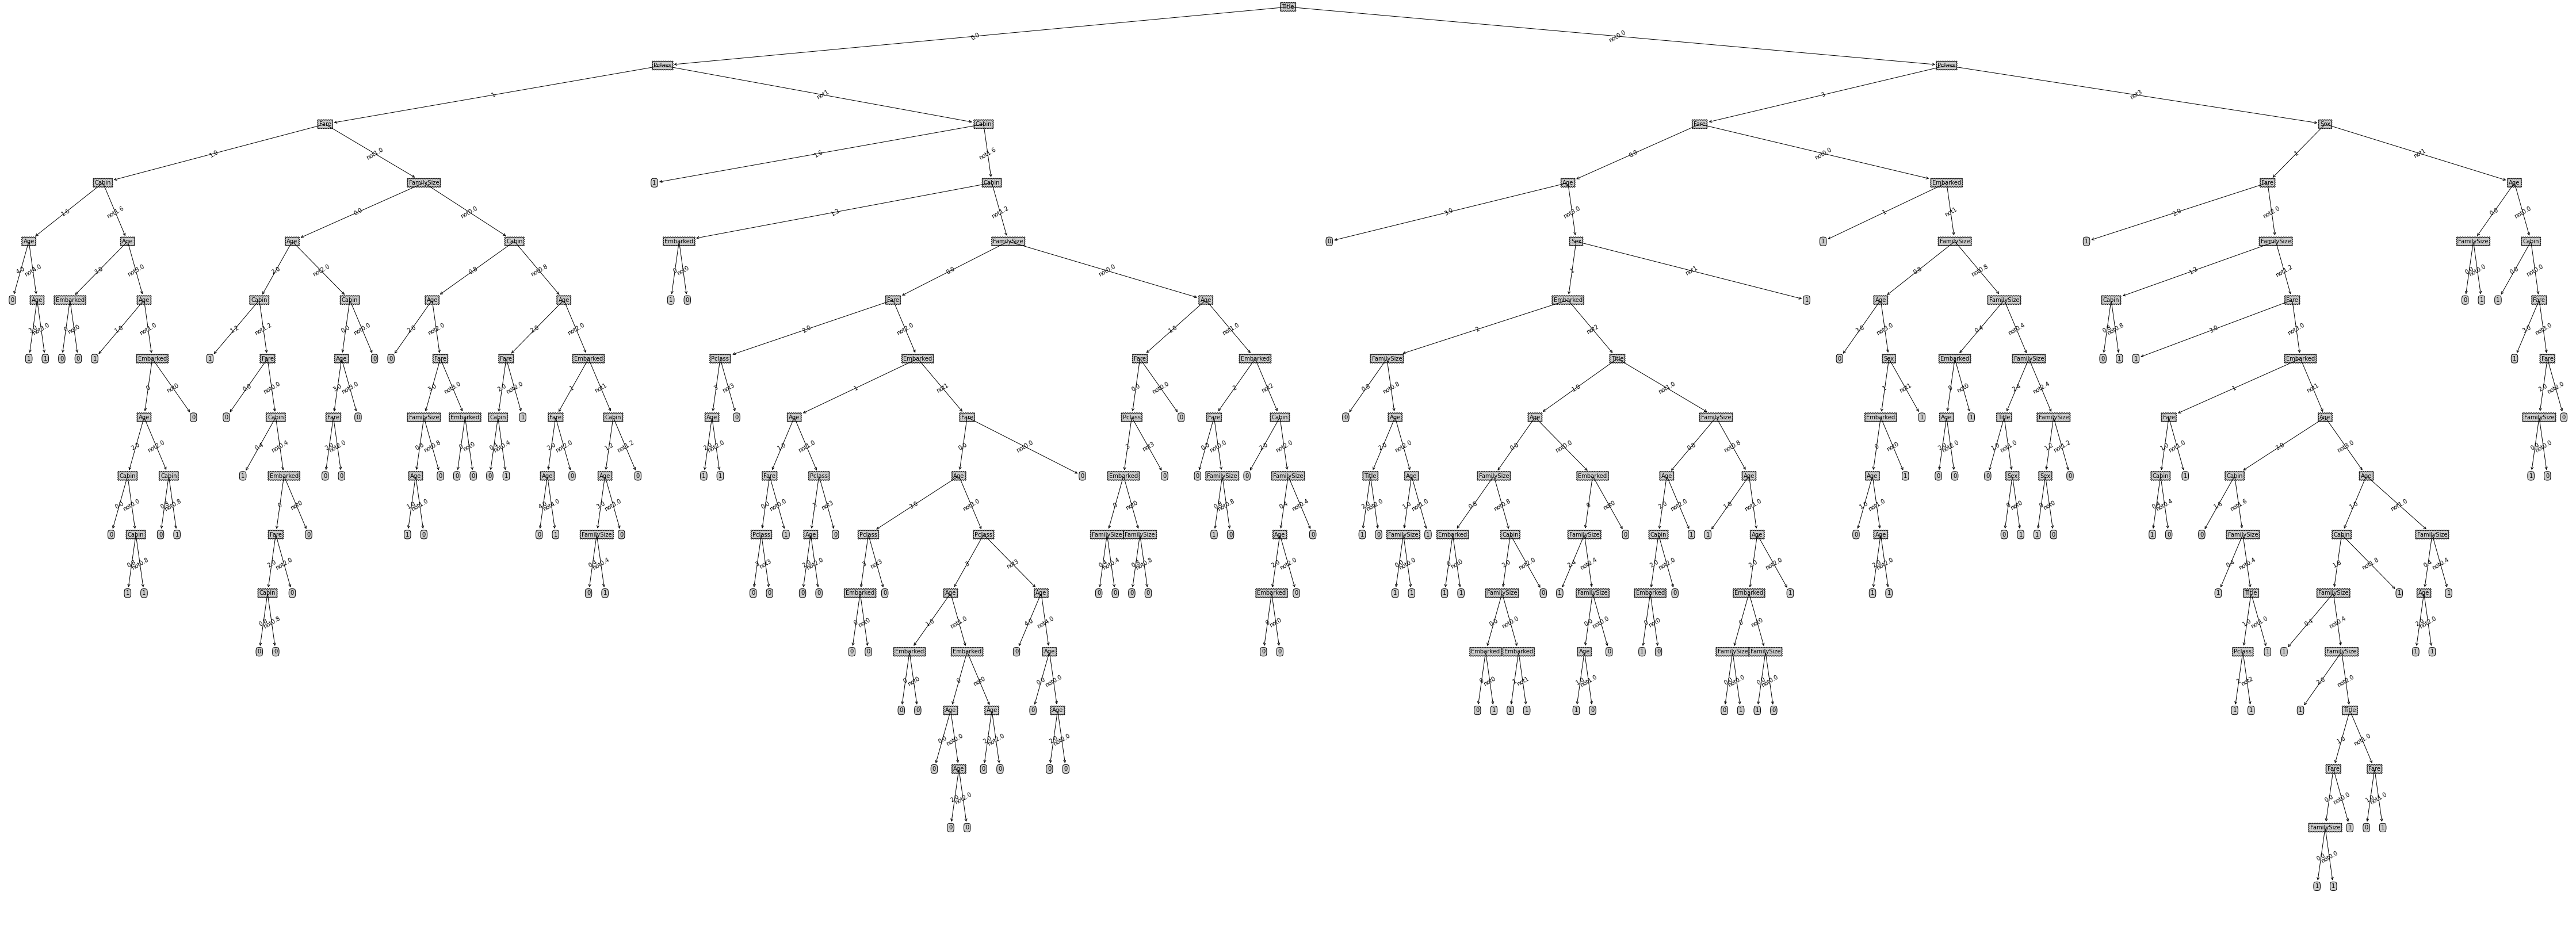

In [151]:
PlotTree().createPlot(tree)

# AdaBoost
> 无知的我写决策树的时候没有预留权重。。。重新写代码又好麻烦。。。。最后只好用一个十分简陋的弱分类器

In [152]:
def train(x, y, w):
    min_loss = 1
    m = x.shape[1]
    res_k = None
    nums = 1000
    for i in range(nums):
        k_random = []
        for j in range(m):
           k_random.append(np.random.uniform(0, 1))
        k_random = np.array(k_random)
        err = (k_random * x).sum(axis = 1)
        err = err - min(err)
        err = err / max(err)
        res = []
        for item in err:
            if item <= 0.5:
                res.append(0)
            else:
                res.append(1)
        res = np.array(res)
        errs = sum((res != y) * w)
        if errs < min_loss:
            min_loss = errs
            res_k = k_random
        if i <= 1:
            print("单独弱分类器的正确率为{:4f}%".format(sum(res == y) / x.shape[0] * 100))
    return min_loss, res_k

In [153]:
w_m = np.ones(data_x.shape[0]) / data_x.shape[0]
train(data_x, data_y, w_m)

单独弱分类器的正确率为58.361392%
单独弱分类器的正确率为65.993266%


(0.24466891133557725,
 array([0.06225327, 0.99601654, 0.28147085, 0.18828633, 0.6625562 ,
        0.05665001, 0.78101366, 0.14565773]))

In [154]:
def predict(x, res_k):
    err = (res_k * x).sum(axis=1)
    err = err - min(err)
    err = err / max(err)
    res = []
    for item in err:
        if item <= 0.5:
            res.append(0)
        else:
            res.append(1)
    res = np.array(res)
    return res

In [155]:
def adaboost(x, y):
    n = x.shape[0]
    run = 4
    weight = np.ones(n) / n
    res = np.zeros(n)
    for m in range(run):
        err, res_k = train(x, y, weight)
        alpha = 0.5 * np.log((1 - err)/err)
        pred = predict(x, res_k)
        weight *= np.exp(-alpha * y * pred) + 1e-4
        weight /= 2 * np.sqrt(err * (1 - err))
        res += alpha*pred
    res = res - min(res)
    res = res / max(res)
    result = []
    for item in res:
        if item <= 0.5:
            result.append(0)
        else:
            result.append(1)
    result = np.array(result)
    print("使用adaboost后的正确率为{:4f}%".format(sum(result == y) / n * 100))

In [123]:
adaboost(data_x, data_y)

单独弱分类器的正确率为60.269360%
单独弱分类器的正确率为58.361392%
单独弱分类器的正确率为65.544332%
单独弱分类器的正确率为49.831650%
单独弱分类器的正确率为69.248036%
单独弱分类器的正确率为62.850730%
单独弱分类器的正确率为59.259259%
单独弱分类器的正确率为60.157127%
使用adaboost后的正确率为74.410774%
